In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from bayesiankalman import mcmc
from tqdm import tqdm_notebook
import cdpm
from sklearn.preprocessing import add_dummy_feature

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=2, suppress=True)

In [3]:
alpha_for_ci = .95
num_draws = int(5e3)
include_mean = False
time_dim=2000
filename = '../results/multivariate_simulation.tmp.hdf'

In [4]:
num_assets = 5

In [5]:
rel_cols = ['Asset {}'.format(n) for n in range(num_assets)]

In [6]:
percentiles = [1,5, 25, 50, 75, 95, 99]

## Simulate the Data

In [7]:
mu = [0.8, 0.2]
prop_mean=[1.5,1.5] 
prop_coeff=.5
sigma=1
beta = .9 * np.eye(num_assets)

In [8]:
data =  cdpm.simulate_multiv_regime_switching(beta, mu, sigma, prop_mean, prop_coeff,time_dim=time_dim)

In [9]:
data.head()

Asset 0   Asset 1   Asset 2   Asset 3   Asset 4  Regime
1995-01-01  0.267001  0.876954 -2.024010 -1.236585  0.691198     0.0
1995-01-08  1.800947  0.714892 -2.470452 -2.384392 -0.042241     0.0
1995-01-15  0.635474  0.733182 -0.803769 -1.002522 -1.201675     0.0
1995-01-22  0.035336 -0.620031 -1.774476 -2.162438 -1.854323     1.0
1995-01-29  0.647304  0.015489 -0.464347 -1.150213 -1.775143     1.0

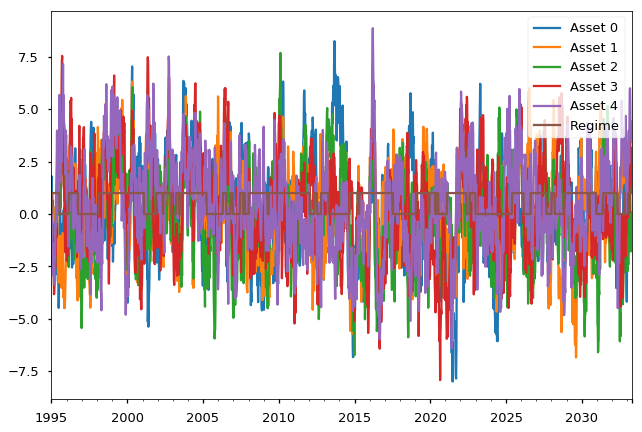

In [10]:
data.plot()

In [11]:
data.describe()

Asset 0      Asset 1      Asset 2      Asset 3      Asset 4  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000   
mean      0.052365     0.039961    -0.217341     0.265502     0.392582   
std       2.361199     2.155519     2.202647     2.373124     2.215182   
min      -8.002413    -6.856494    -6.762919    -7.934340    -6.403741   
25%      -1.543356    -1.414019    -1.803454    -1.415797    -1.062875   
50%      -0.006759     0.060672    -0.200298     0.181082     0.286204   
75%       1.582890     1.559800     1.298757     1.728736     1.772574   
max       8.254958     6.323902     7.694356     7.551534     8.874464   

            Regime  
count  2000.000000  
mean      0.603500  
std       0.489293  
min       0.000000  
25%       0.000000  
50%       1.000000  
75%       1.000000  
max       1.000000

## Estimation

In [12]:
time_dim = data.shape[0]
regressor_dim = len(rel_cols) + np.int(include_mean)
regressand_dim = len(rel_cols)

In [13]:
stick_scale = 1
# mean and standard deviation
beta_mu, beta_sigma = 1 * np.eye(regressand_dim,regressor_dim, k=-1), .005 * np.eye(regressor_dim, regressor_dim) 
comp_cov_nu = 3
comp_cov_mu = 3
comp_std_mean = .25
comp_cov_mean = comp_std_mean**2 * np.ones(regressand_dim)

In [14]:
prior = {
    'coeff': {'mean':list(beta_mu.ravel()), 'cov': list(beta_sigma.ravel())},
    'cov':  {'scale': list(comp_cov_mean), 'nu': comp_cov_nu, 'mu': comp_cov_mu, 'hierarchical': True},
    'expected_cluster_dim': stick_scale,
}

In [15]:
if include_mean:
    regressor =  pd.DataFrame(add_dummy_feature(data.iloc[:-1, :-1]), index=data.index[:-1],
                             columns=['intercept'] + list(data.columns[:-1]))
else:
    regressor = data.iloc[:-1,:-1]
    
regressand = data.iloc[1:, :-1]

## Estimation 

In [18]:
return_dict = cdpm.estimate_cdpm(regressor=regressor,regressand=regressand, num_draws=num_draws, 
                                 progress_bar=tqdm_notebook, prior=prior,filename=filename,
                                 data=data, clusters=5)

In [19]:
cluster_identity_draws = return_dict['cluster_identity']
stick_draws = return_dict['sticks']
beta_draws = return_dict['beta']
comp_cov_draws = return_dict['comp_cov']
trans_mat_draws = return_dict['trans_mat']

## Simulation Results

In [20]:
state_quantiles = np.percentile(cluster_identity_draws, percentiles, axis=0)

In [21]:
trans_mat = pd.DataFrame(np.nanmean(trans_mat_draws[:, :10, :10], axis=0))
trans_mat.dropna(axis=0, how='all').dropna(axis=1, how='all')

0         1         2         3         4         5
0  0.227975  0.191821  0.174782  0.172836  0.164163  0.153628
1  0.194974  0.216423  0.182877  0.172354  0.165086  0.153436
2  0.193738  0.179241  0.214772  0.176651  0.165770  0.156261
3  0.191963  0.179529  0.176969  0.216490  0.166600  0.154030
4  0.185933  0.171921  0.170839  0.166313  0.211991  0.154862
5  0.171757  0.160424  0.159557  0.153236  0.151593  0.203425

In [22]:
stationary_dist = cdpm.compute_stationary_distribution(trans_mat_draws)

In [23]:
stationary_dist.mean().cumsum()

0    0.194834
1    0.380189
2    0.564259
3    0.749266
4    0.910272
5    0.999944
dtype: float64

## Parameter Estimates 

In [24]:
beta_est = np.nanmean(beta_draws, axis=0)
beta_est[np.all(np.isfinite(beta_est), axis=(-2,-1))]

array([[[ 0.8 ,  0.15, -0.  , -0.02,  0.01],
        [ 0.03,  0.72,  0.15, -0.01, -0.  ],
        [ 0.01, -0.01,  0.73,  0.21, -0.04],
        [ 0.01,  0.01,  0.03,  0.73,  0.19],
        [-0.  ,  0.02,  0.01,  0.02,  0.73]],

       [[ 0.78,  0.17, -0.  , -0.02,  0.01],
        [ 0.02,  0.7 ,  0.18, -0.  , -0.01],
        [ 0.02, -0.02,  0.71,  0.22, -0.05],
        [ 0.01,  0.01,  0.03,  0.71,  0.21],
        [-0.01,  0.02,  0.01,  0.03,  0.71]],

       [[ 0.8 ,  0.15, -0.01, -0.02,  0.01],
        [ 0.02,  0.72,  0.16, -0.01, -0.01],
        [ 0.02, -0.01,  0.73,  0.2 , -0.05],
        [ 0.01,  0.01,  0.03,  0.73,  0.19],
        [-0.  ,  0.02,  0.01,  0.03,  0.73]],

       [[ 0.8 ,  0.15, -0.  , -0.02,  0.01],
        [ 0.02,  0.72,  0.16, -0.  , -0.01],
        [ 0.02, -0.02,  0.73,  0.2 , -0.05],
        [ 0.01,  0.01,  0.03,  0.73,  0.19],
        [-0.  ,  0.02,  0.01,  0.02,  0.73]],

       [[ 0.8 ,  0.15, -0.  , -0.02,  0.01],
        [ 0.02,  0.72,  0.16, -0.01, -0.01],
  

In [25]:
cov_est = np.nanmean(comp_cov_draws, axis=0)
cov_est[np.all(np.isfinite(cov_est), axis=(-2,-1))]

array([[[ 1.62, -0.01,  0.35,  0.2 ,  0.13],
        [-0.01,  1.93, -0.06,  0.26,  0.18],
        [ 0.35, -0.06,  1.83, -0.06,  0.22],
        [ 0.2 ,  0.26, -0.06,  1.74, -0.06],
        [ 0.13,  0.18,  0.22, -0.06,  1.71]],

       [[ 1.66, -0.06,  0.36,  0.2 ,  0.13],
        [-0.06,  2.01, -0.08,  0.27,  0.17],
        [ 0.36, -0.08,  1.89, -0.1 ,  0.22],
        [ 0.2 ,  0.27, -0.1 ,  1.81, -0.09],
        [ 0.13,  0.17,  0.22, -0.09,  1.77]],

       [[ 1.6 ,  0.03,  0.38,  0.22,  0.15],
        [ 0.03,  1.92, -0.02,  0.28,  0.17],
        [ 0.38, -0.02,  1.8 , -0.04,  0.23],
        [ 0.22,  0.28, -0.04,  1.72, -0.04],
        [ 0.15,  0.17,  0.23, -0.04,  1.69]],

       [[ 1.59,  0.01,  0.36,  0.21,  0.14],
        [ 0.01,  1.91, -0.03,  0.27,  0.17],
        [ 0.36, -0.03,  1.79, -0.05,  0.23],
        [ 0.21,  0.27, -0.05,  1.7 , -0.05],
        [ 0.14,  0.17,  0.23, -0.05,  1.68]],

       [[ 1.59, -0.01,  0.36,  0.21,  0.14],
        [-0.01,  1.92, -0.05,  0.27,  0.16],
  

## Forecasting

In [26]:
data_est_mat = cdpm.forecast_draws(cluster_identity_draws, trans_mat_draws, beta_draws, comp_cov_draws, 
                                   regressor)

In [27]:
np.mean([np.corrcoef(val) for val in data_est_mat.T], axis=0)

array([[1.  , 0.38, 0.36, 0.23, 0.17],
       [0.38, 1.  , 0.33, 0.29, 0.23],
       [0.36, 0.33, 1.  , 0.45, 0.33],
       [0.23, 0.29, 0.45, 1.  , 0.42],
       [0.17, 0.23, 0.33, 0.42, 1.  ]])

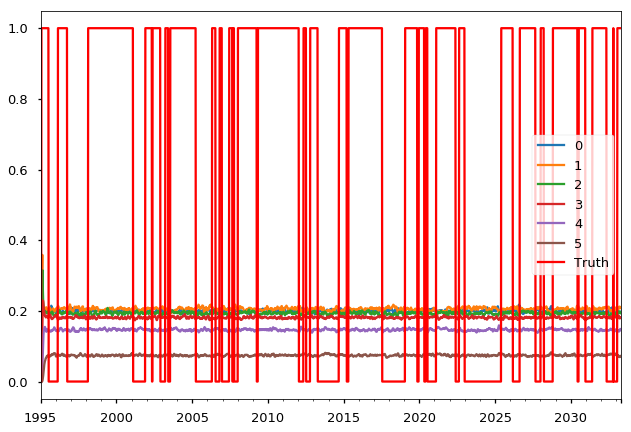

In [28]:
posterior_cluster_probs = pd.DataFrame(np.column_stack([np.mean(cluster_identity_draws == idx, axis=0) 
                           for idx in np.unique(cluster_identity_draws)]), index=data.index[1:])
cluster_probs_fig, cluster_probs_ax = mpl.pyplot.subplots()
posterior_cluster_probs.rolling(5).mean().plot(ax=cluster_probs_ax)
data.Regime.plot(ax=cluster_probs_ax, color='red', label='Truth')
cluster_probs_ax.legend()

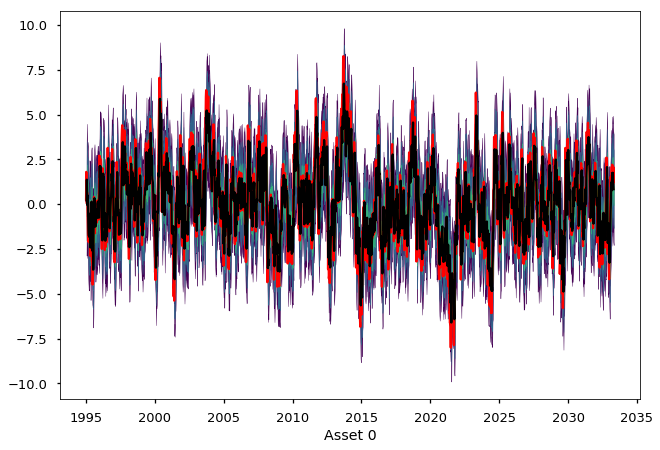

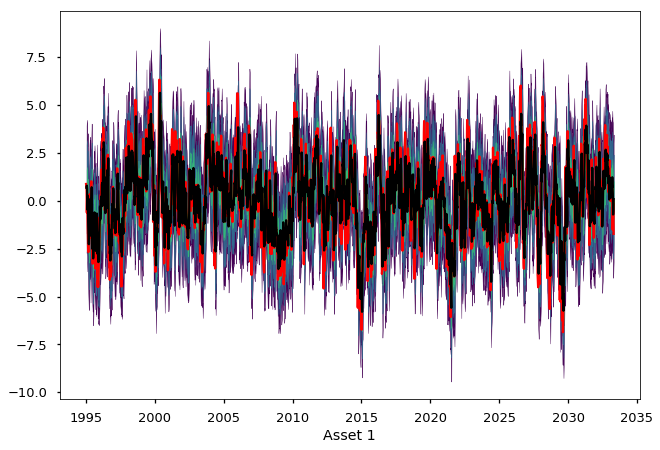

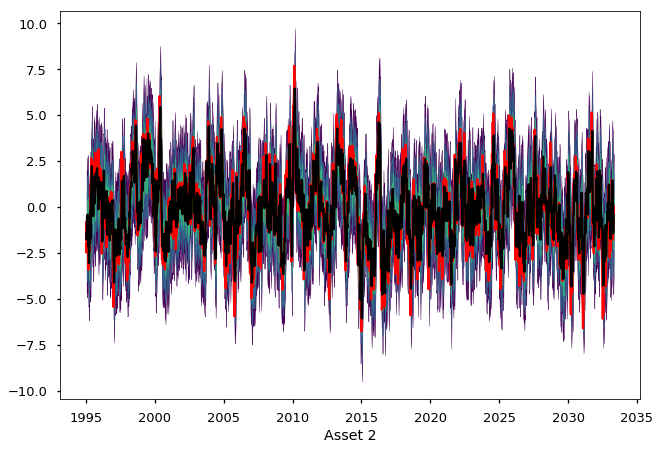

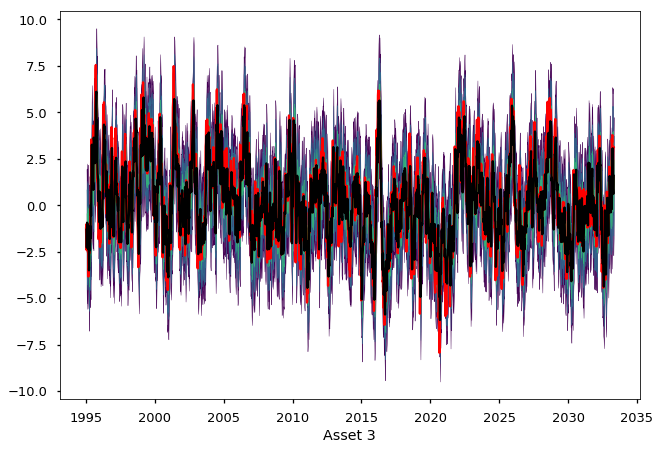

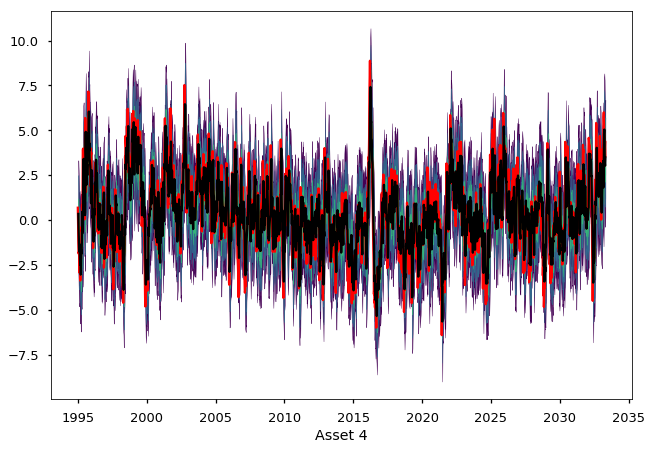

In [29]:
for idx, val in enumerate(rel_cols):
    data_thing = pd.DataFrame(np.squeeze(data_est_mat[:,idx,:]), index=data.index[2:])
    data_comparison_fig, data_comparison_ax = mpl.pyplot.subplots(1,1)
    mcmc.fan_plot(data_comparison_ax, data_thing, percentiles, color='black')
    data_comparison_ax.plot(data[val].dropna(), color='red')
    data_comparison_ax.set_xlabel(val)

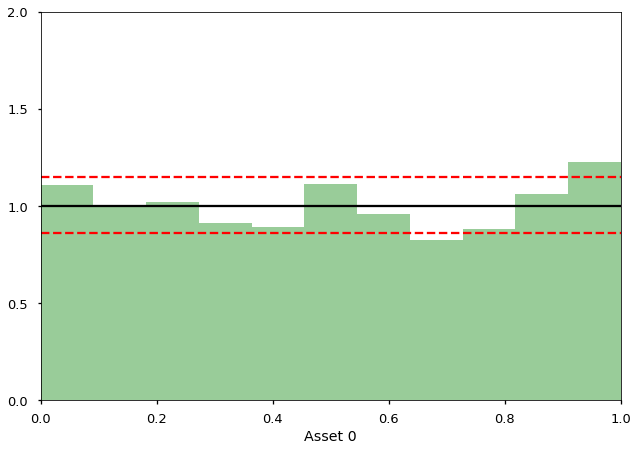

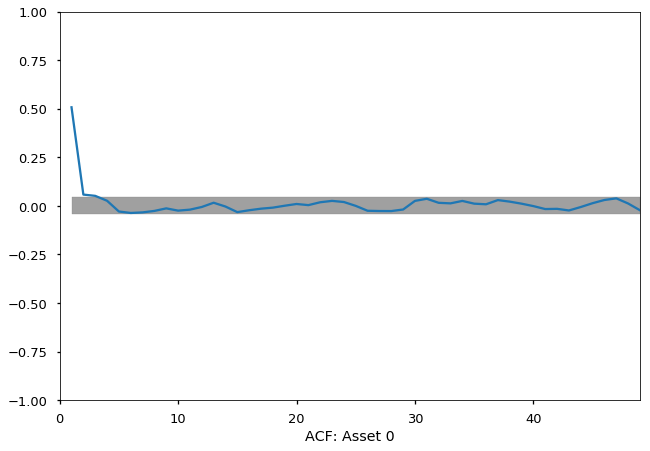

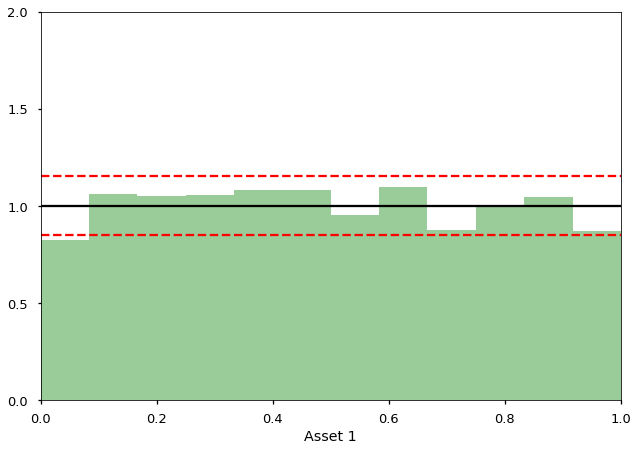

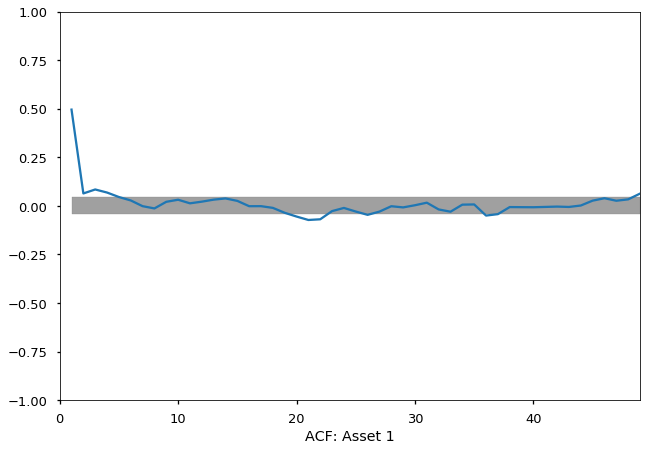

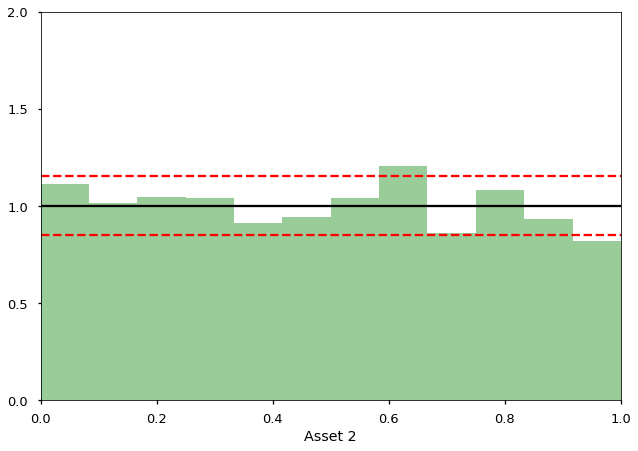

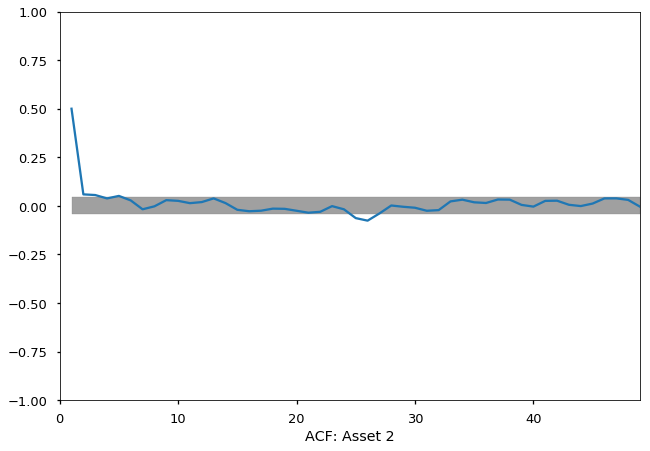

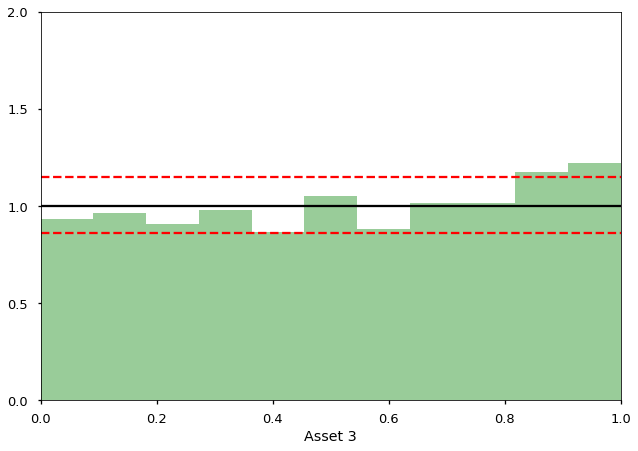

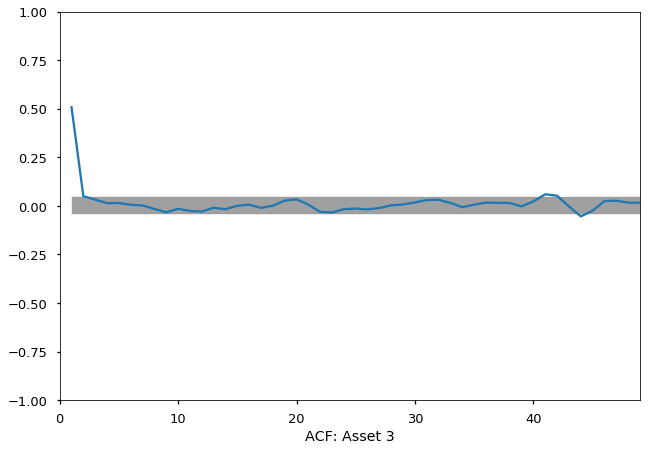

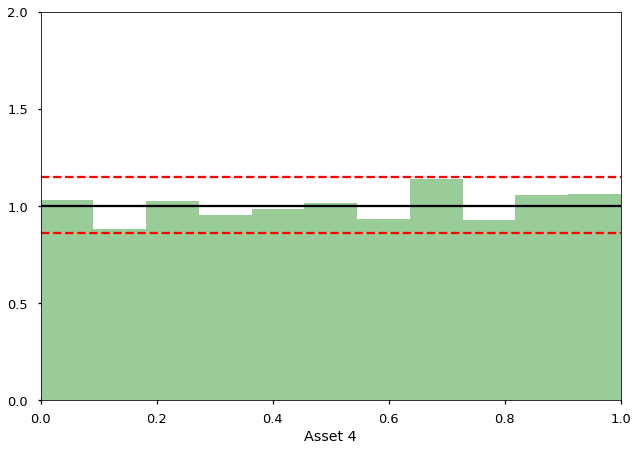

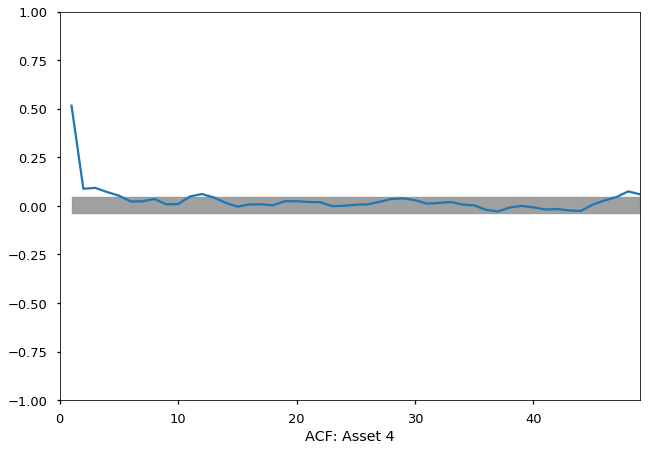

In [30]:
for idx, val in enumerate(rel_cols):
    data_thing = pd.DataFrame(np.squeeze(data_est_mat[:,idx,:]), index=data.index[2:])

    pit = mcmc.probability_integral_transform(data_thing, data[val].iloc[2:])
    pit_fig, pit_ax = mpl.pyplot.subplots()
    cdpm.pit_plot(pit, ax=pit_ax, pct=.95, color='green')
    pit_ax.set_xlabel(val)
    pit_fig.savefig(f'../doc/density_figures/{val}_pit.tmp.pdf', bbox_inches='tight', pad_inches=0,
                    transparent=True, frameon=False)
    
    acf_fig, acf_ax = mpl.pyplot.subplots()
    cdpm.pit_acf_plot(pit, ax=acf_ax, color='grey', alpha=.75)
    acf_ax.set_xlabel(f'ACF: {val}')
    acf_fig.savefig(f'../doc/density_figures/{val}_acf.tmp.png', bbox_inches='tight', pad_inches=0)